# Tutorial SEGMOOMOE via web services

This notebook describes the usage of segomoe using web services exposed by WhatsOpt.

## Prerequisite

### wop (WhatsOpt command line interface)

You have to install the `wop` command:

```bash
pip install -U wop 
```

You need to be logged in a WhatsOpt server either by using the <code>wop</code> command in a shell or the WhatsOpt API as follows:

In [1]:
from whatsopt.whatsopt_client import WhatsOpt
wop = WhatsOpt(url="https://ether.onera.fr/whatsopt")
ok = wop.login(echo=True)

# If you have any trouble with the previous command 
# then logout to ensure to start from a clean slate and retry
if not ok: 
    wop.logout() 

Successfully logged in to remote WhatsOpt https://ether.onera.fr/whatsopt



To test if you are connected the following command should succeed

In [2]:
wop.check_versions()

WhatsOpt 1.22.2 requires wop >= 1.20.0
You are using wop 2.1.0b0


### SMT (Surrogate Modeling Toolbox)

SMT is not required per se, but is used in this notebook to get optimized LHS sampling method.

```bash
pip install smt
```

## Optimization with constraints

### Objective function

First we define the objective function we want to minimize

In [3]:
import numpy as np
from smt.applications.mixed_integer import FLOAT, INT

def fun(x):  # function with 2 objectives
    x = np.atleast_2d(x)
    f1 = x[:, 0] - x[:, 1] * x[:, 2]
    f2 = 4 * x[:, 0] ** 2 - 4 * x[:, 0] ** x[:, 2] + 1 + x[:, 1]
    f3 = x[:, 0] ** 2
    return np.hstack((np.atleast_2d(f1).T, np.atleast_2d(f2).T, np.atleast_2d(f3).T))


def g1(x):  # constraint to force x < 0.8
    x = np.atleast_2d(x)
    return np.atleast_2d(x[:, 0] - 0.8).T


def g2(x):  # constraint to force x > 0.2
    x = np.atleast_2d(x)
    return np.atleast_2d(0.2 - x[:, 0]).T


def f_grouped(x):
    resfun = fun(x)
    resg1 = g1(x)
    resg2 = g2(x)
    res = np.hstack((resfun, resg1, resg2))
    return res

### Optimization

First we create an optimization context to use the SEGMOOMOE optimizer with the design space <code>xlimits</code>.

In [4]:
from whatsopt.mooptimization import MOOptimization, FLOAT, INT

xtypes = [{"type": FLOAT, "limits": [0., 1.]},
          {"type": INT, "limits": [0, 3]},
          {"type": INT, "limits": [0, 3]}]

cstr_specs = 2*[{"type": '<', "bound": 0.0}]

options={"n_clusters": 0, "n_start": 10, "criterion": "PI", "pop_size": 30, "n_gen": 30, "verbose": True, "debug": True}

optim = MOOptimization(xtypes, n_obj=3, cstr_specs=cstr_specs, options=options)

We need to have an initial DOE (n_samples, nx) and the corresponding outputs y (n_samples, 1).

In [5]:
import numpy as np
# from smt.sampling_methods import LHS
# lhs = LHS(xlimits=np.array(xlimits), criterion='ese')
# xdoe = lhs(5)

xdoe = np.array(
    [        
     [0.36691555, 0.,        1.        ],
     [0.58432706, 1.,       1.        ],
     [0.09227899, 1.,         2.        ],
     [0.95274182, 1.,         2.        ],
     [0.72873502, 1.,         3.        ],
     [0.87115983, 2.,         1.        ],
     [0.24346361, 2.,         3.        ],
     [0.4221473 , 2.,         0.        ],
     [0.10886813, 2.,         1.        ],
     [0.65557784, 3.,         2.        ],
     [0.39532629, 2.,         0.        ]
    ]
)
ydoe = f_grouped(xdoe)
print("Initial DOE")
print("xdoe={}".format(xdoe))
print("ydoe={}".format(ydoe))

Initial DOE
xdoe=[[0.36691555 0.         1.        ]
 [0.58432706 1.         1.        ]
 [0.09227899 1.         2.        ]
 [0.95274182 1.         2.        ]
 [0.72873502 1.         3.        ]
 [0.87115983 2.         1.        ]
 [0.24346361 2.         3.        ]
 [0.4221473  2.         0.        ]
 [0.10886813 2.         1.        ]
 [0.65557784 3.         2.        ]
 [0.39532629 2.         0.        ]]
ydoe=[[ 0.36691555  0.07084588  0.13462702 -0.43308445 -0.16691555]
 [-0.41567294  1.02844421  0.34143811 -0.21567294 -0.38432706]
 [-1.90772101  2.          0.00851541 -0.70772101  0.10772101]
 [-1.04725818  2.          0.90771698  0.15274182 -0.75274182]
 [-2.27126498  2.5762262   0.53105473 -0.07126498 -0.52873502]
 [-1.12884017  2.55103848  0.75891945  0.07115983 -0.67115983]
 [-5.75653639  3.17937335  0.05927453 -0.55653639 -0.04346361]
 [ 0.4221473  -0.28716663  0.17820834 -0.3778527  -0.2221473 ]
 [-1.89113187  2.61193656  0.01185227 -0.69113187  0.09113187]
 [-5.34442216 

We initialize the optimizer with the inital DOE.

In [6]:
optim.tell_doe(xdoe, ydoe)

We trigger the optimization using the "ask and tell" interface.

In [7]:
# We loop using the iteration budget
n_iter = 2
with_best=False
for i in range(n_iter):
    with_best = with_best or (i == n_iter - 1)
    x_suggested, status, x_opt, y_opt = optim.ask(with_best)
    print("{} x suggested = {} with status: {}".format(i, x_suggested, MOOptimization.STATUSES[status]))

    # compute objective function at the suggested point
    new_y = f_grouped(x_suggested)
    print("new y = {}".format(new_y))

    optim.tell(x_suggested, new_y)
         
print("Found approx pareto y_opt = {} at x_opt = {}".format(y_opt, x_opt))

0 x suggested = [0.22551914855701133, 3.0, 1.0] with status: valid point
new y = [[-2.77448085  3.30135895  0.05085889 -0.57448085 -0.02551915]]
1 x suggested = [0.3916331175359278, 1.0, 1.0] with status: valid point
new y = [[-0.60836688  1.04697352  0.1533765  -0.40836688 -0.19163312]]
Found approx pareto y_opt = [[-5.759582114765303, 3.178996061831344, 0.060950745522340366], [-1.0706073834669039, 2.024251386367329, 0.7141219260251254], [0.3924548714638407, -0.37423790178367033, 0.1546337831944528], [-6.715590913255226, 2.238692719201108, 0.24781707426633254], [-0.258911316841995, 1.7152775356721865, 0.04156651321522414], [-1.0353258989267422, 1.9000160080301245, 0.6371008429788545], [-1.7197066989632734, 2.214999952279676, 0.5448390664112407], [-5.790678122556858, 3.089522005884157, 0.08616346269207986], [-2.243730961609703, 2.2386927090330215, 0.28006136833295175], [-5.210588632718002, 2.238692709801892, 0.22839608482139714], [-1.7651262433225559, 2.2265242346971057, 0.455201938442

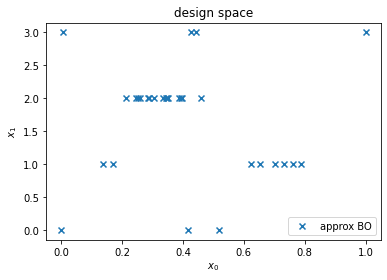

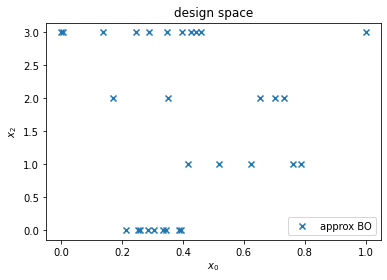

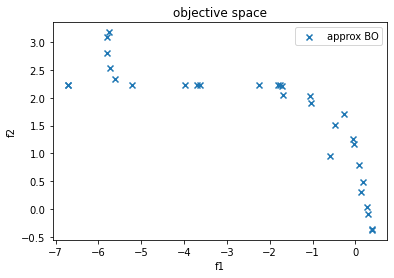

In [8]:
import matplotlib.pyplot as plt

x_opt = np.array(x_opt)
y_opt = np.array(y_opt)

plt.figure()
plt.scatter(x_opt[:,0], x_opt[:,1], marker='x',label = 'approx BO')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.legend()
plt.title("design space")
plt.show()


plt.figure()
plt.scatter(x_opt[:,0], x_opt[:,2], marker='x',label = 'approx BO')
plt.xlabel('$x_0$')
plt.ylabel('$x_2$')
plt.legend()
plt.title("design space")
plt.show()

plt.figure()
plt.scatter( y_opt[:,0],  y_opt[:,1],marker='x', label = 'approx BO')
plt.xlabel('f1')
plt.ylabel('f2')
plt.legend()
plt.title("objective space")
plt.show()

In [9]:
optim.tell_doe(xdoe, ydoe)

In [10]:
x_opt, y_opt = optim.run(f_grouped, n_iter=5)

0 x suggested = [0.7964018758271046, 3.0, 3.0] with status: valid point
new y = [[-8.20359812e+00  4.51653328e+00  6.34255948e-01 -3.59812417e-03
  -5.96401876e-01]]
1 x suggested = [0.20230492611129244, 3.0, 3.0] with status: valid point
new y = [[-8.79769507e+00  4.13058997e+00  4.09272831e-02 -5.97695074e-01
  -2.30492611e-03]]
2 x suggested = [0.5011198260695624, 1.0, 1.0] with status: valid point
new y = [[-0.49888017  1.00000502  0.25112108 -0.29888017 -0.30111983]]
3 x suggested = [0.2000010030148385, 3.0, 2.0] with status: valid point
new y = [[-5.79999900e+00  4.00000000e+00  4.00004012e-02 -5.99998997e-01
  -1.00301484e-06]]
4 x suggested = [0.5914676347473176, 1.0, 3.0] with status: valid point
x_best=[[0.20519806200253976, 2.0, 3.0], [0.3421611104462972, 1.0, 0.0], [0.21298585699820932, 0.0, 2.0], [0.205020037190084, 3.0, 3.0], [0.9261337763384468, 0.0, 3.0], [0.544309804131578, 0.0, 0.0], [0.7904229837684503, 0.0, 3.0], [8.722785937742561e-05, 3.0, 3.0], [0.908878208852480

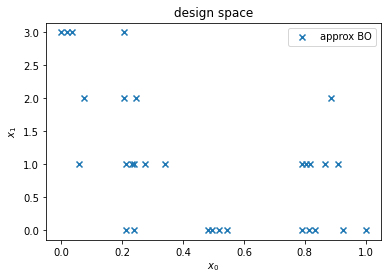

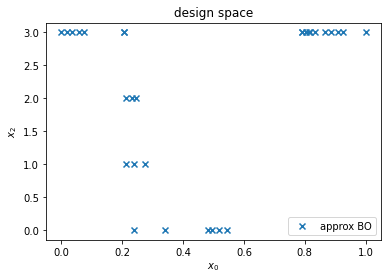

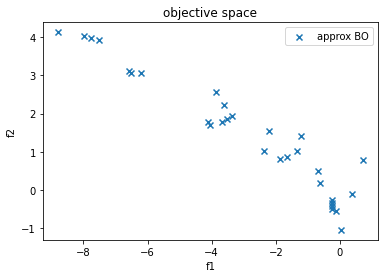

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(x_opt[:,0], x_opt[:,1], marker='x',label = 'approx BO')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.legend()
plt.title("design space")
plt.show()


plt.figure()
plt.scatter(x_opt[:,0], x_opt[:,2], marker='x',label = 'approx BO')
plt.xlabel('$x_0$')
plt.ylabel('$x_2$')
plt.legend()
plt.title("design space")
plt.show()

plt.figure()
plt.scatter( y_opt[:,0],  y_opt[:,1],marker='x', label = 'approx BO')
plt.xlabel('f1')
plt.ylabel('f2')
plt.legend()
plt.title("objective space")
plt.show()